# 3行で
- 一列の複数の要素を含んでいる`genres`, `studios`, `producers`, `licensors`について、それぞれの要素のone-hot encodingと、scoreのuser_id毎の平均の相関係数(pearson)を確認した。
- 各要素に対する相関係数について、正の相関・負の相関が最も高いのは、それぞれ`genres`の`Drame`と`Ecchi`だった
- 京アニは、`studios`の要素の中での相関係数が4/190位

# 初めに
京都アニメーションさんと`score`の相関は高いのでは？と気になったため、`studios`の各要素のone-hot encodingと、scoreのuser_id毎の平均の相関係数(pearson)を調べました。

合わせて、`studios`と同様に一列の複数の要素を含んでいる`genres`, `producers`, `licensors`についてもscoreとの相関を確認しました。

polarsを使っています。

In [47]:
import polars as pl
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import japanize_matplotlib

In [48]:
!python --version

Python 3.11.3


In [49]:
pl.__version__

'0.18.7'

In [50]:
pl.Config.set_fmt_str_lengths(100)

polars.config.Config

In [51]:
train = pl.read_csv("../../data/train.csv")
anime = pl.read_csv("../../data/anime.csv")

In [52]:
anime_score_agg_df = train.join(anime, on="anime_id", how="left").groupby("anime_id").agg(
    pl.count("score").alias("anime_score_count"),
    pl.mean("score").alias("anime_score_mean")
)

anime = anime.join(anime_score_agg_df, on="anime_id", how="left").filter(
    pl.col("anime_score_mean").is_not_null() # 誰もscoreをつけていないanimeは除外
)

In [53]:
def get_one_hot_df(df: pl.DataFrame, col: str) -> pl.DataFrame:
    mlb = MultiLabelBinarizer()

    col_sr = df.get_column(col).apply(lambda x: x.split(", "))
    one_hot = mlb.fit_transform(col_sr)
    one_hot_df = pl.DataFrame(one_hot)
    one_hot_df.columns = [f"{name}" for name in mlb.classes_]

    one_hot_with_score_df = pl.concat([df.select("anime_score_mean"), one_hot_df], how="horizontal")

    return one_hot_with_score_df

def get_corr_df(df: pl.DataFrame, col: str) -> pl.DataFrame:
    df = get_one_hot_df(df, col)
    corr_df = df.corr().transpose(include_header=True, column_names=[f"corr_{col}"for col in df.columns]).sort("corr_anime_score_mean", descending=True)
    corr_df = corr_df.select(["column", "corr_anime_score_mean"])
    corr_df = corr_df.slice(1) # 1行目はanime_score_mean自身の相関係数なので除外
    return corr_df

In [54]:
def view_barh_plot(df: pl.DataFrame) -> None:
    if df.height > 50:
        df = pl.concat([df.head(25), df.tail(25)])
    plt.figure(figsize=(8, df.height // 5))
    plt.barh(df.get_column("column"), df.get_column("corr_anime_score_mean")) 
    plt.xlim(-0.3, 0.3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.xlabel("相関係数")

In [55]:
def display_filter_df(df: pl.DataFrame, col: str, name: str) -> None:
    out = anime.filter(
        pl.col(col).str.contains(name)
    ).select(
        [col, "japanese_name", "anime_score_mean", "anime_score_count"]
    ).sort("anime_score_mean", descending=True)
    
    display(out)

# genres
`作品ジャンル. (複数)`

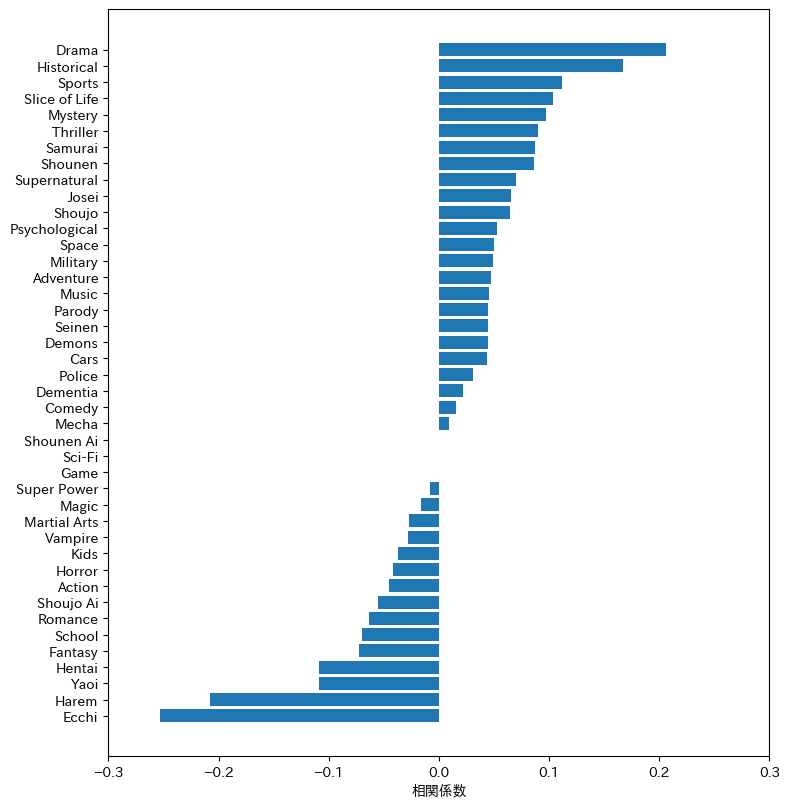

In [56]:
res_genres = get_corr_df(anime, "genres")
view_barh_plot(res_genres)

`Drama`が一位でした。
`Drame`にはどのようなアニメが該当するか見てみます。

In [57]:
display_filter_df(anime, "genres", "Drama")

genres,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Drama, Fantasy, Slice of Life""","""獣の奏者エリン""",9.25,8
"""Military, Sci-Fi, Space, Drama""","""銀河英雄伝説""",9.210526,19
"""Drama, Game, Seinen, Slice of Life""","""3月のライオン 第2シリーズ""",9.205882,68
"""Drama, Historical, Josei""","""昭和元禄落語心中～助六再び篇～""",9.193548,31
"""Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen""","""鋼の錬金術師 FULLMETAL ALCHEMIST""",9.154013,461
"""Slice of Life, Comedy, Supernatural, Drama, Romance""","""CLANNAD〜AFTER STORY〜 クラナド アフターストーリー""",9.09396,298
"""Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power""","""進撃の巨人 Season3 Part.2""",9.04,225
"""Slice of Life, Demons, Supernatural, Drama, Shoujo""","""夏目友人帳 陸""",9.038462,26
"""Slice of Life, Drama, Fantasy""","""劇場版 ヴァイオレット・エヴァーガーデン""",9.0,4


クラナドなどが入っているのを見ると、`Drama`は感動系のアニメが該当するのかもしれません。

次に`Ecchi`を見てみます。

In [58]:
display_filter_df(anime, "genres", "Ecchi")

genres,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Harem, Comedy, Romance, Ecchi, School""","""冴えない彼女の育てかた Fine""",9.111111,9
"""Ecchi, School, Shounen""","""食戟のソーマ""",8.347682,302
"""Action, Comedy, Super Power, Ecchi, School""","""キルラキル""",8.22807,285
"""Game, Adventure, Comedy, Supernatural, Ecchi, Fantasy""","""ノーゲーム・ノーライフ""",8.22276,413
"""Action, Comedy, Ecchi, Fantasy, Harem, Mecha, School""","""異世界の聖機師物語""",8.222222,36
"""Ecchi, School, Shounen""","""食戟のソーマ 弍ノ皿""",8.171296,216
"""Comedy, Supernatural, Romance, Ecchi""","""猫物語（黒）""",8.098592,142
"""Mystery, Comedy, Supernatural, Ecchi""","""憑物語""",8.096491,114
"""Sci-Fi, Harem, Comedy, Supernatural, Ecchi, Shounen""","""そらのおとしもの プロジェクト桃源郷[ピンク]""",8.076923,39


`Ecchi`なんでしょうか🤔　キルラキルは数話見たことがありますが、そうでもないような気がしますね。

# studios
`スタジオ (複数)`

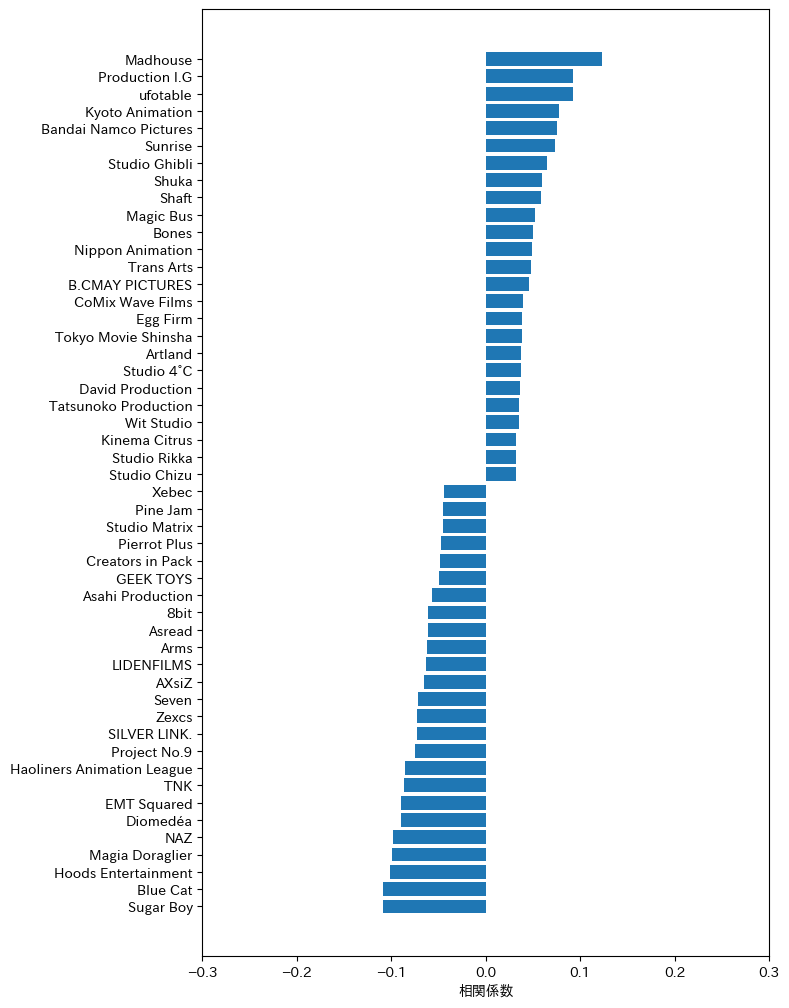

In [59]:
res_studios = get_corr_df(anime, "studios")
view_barh_plot(res_studios)

長すぎたので、途中は省略し、上位25位と下位25位のみを表示しています。

気になっていた京アニさんは4/190位でした。強い。

相関が最も高い`Madhouse`さんを見てみます。

In [60]:
display_filter_df(anime, "studios", "Madhouse")

studios,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Madhouse""","""HUNTER×HUNTER（ハンター×ハンター）""",9.245552,281
"""Madhouse""","""モンスター""",8.989796,98
"""Madhouse""","""NANA [ナナ]""",8.906977,86
"""Madhouse""","""デスノート""",8.792512,641
"""Production I.G, Madhouse""","""ダイヤのA[エース]～Second Season～""",8.785714,28
"""Madhouse""","""RAINBOW 二舎六房の七人""",8.745763,59
"""Madhouse""","""はじめの一歩 THE FIGHTING!""",8.744186,86
"""Madhouse""","""劇場版 カードキャプターさくら 封印されたカード""",8.716981,53
"""Madhouse""","""四畳半神話大系""",8.7,70


HUNTER×HUNTERを作っているところなんですね。

次に、相関が最も低い`Sugar Boy`さんを見てみます。

In [61]:
display_filter_df(anime, "studios", "Sugar Boy")

studios,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Sugar Boy, Blue Cat""","""ぼくのぴこ""",3.962264,53


`Sugar Boy`さんについては、データに含まれている作品数が少ないですね。

# producers
`制作会社. (複数)`

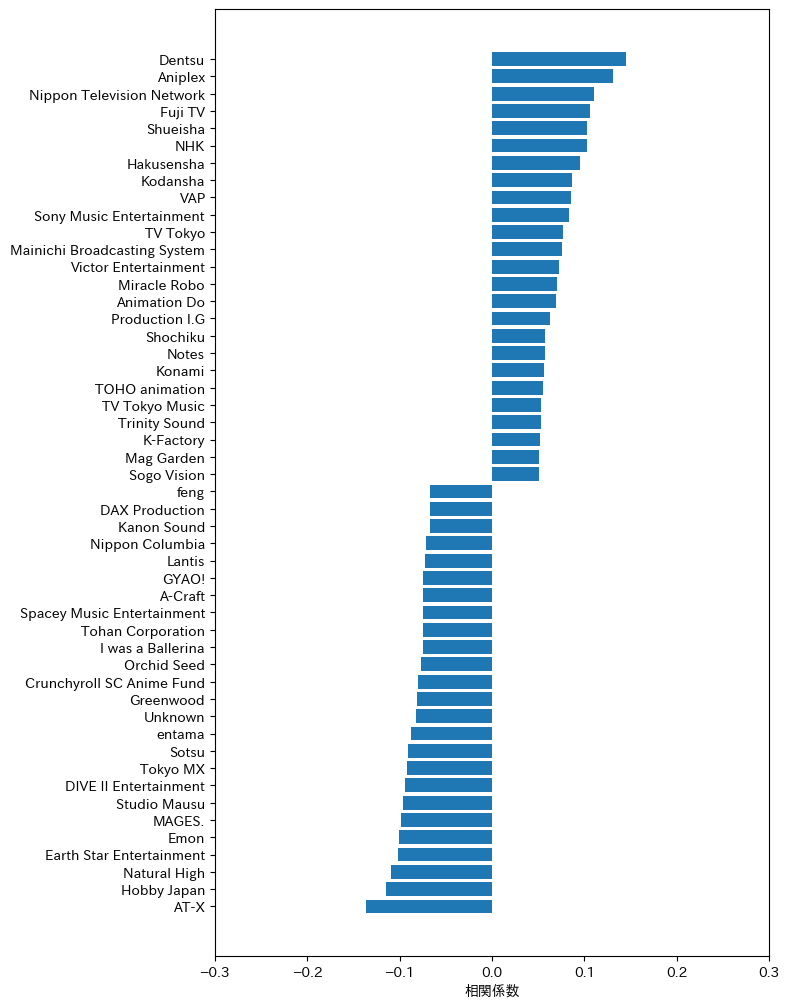

In [62]:
res_producers = get_corr_df(anime, "producers")
view_barh_plot(res_producers)

あまりに長すぎたので、途中は省略し、上位25位と下位25位のみを表示しています。

`studio`では4位だった京アニさんは、`producers`では167/588位でした。

In [63]:
res_producers.slice(166, 10)

column,corr_anime_score_mean
str,f64
"""Kyoto Animation""",0.011857
"""Micro Magazine Publishing""",0.011809
"""Shinshokan""",0.011672
"""Shochiku Music Publishing""",0.011659
"""Imagin""",0.011469
"""Anime Friend""",0.011326
"""Artland""",0.011326
"""Studio Nue""",0.011326
"""TYO""",0.01126


`studio`と`producers`、スタジオと制作会社は何が違うんでしょうか。軽く調べましたが分かりませんでした。

相関が最も高い`Dentsu`さんを見てみます。

In [64]:
display_filter_df(anime, "producers", "Dentsu")

producers,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""TV Tokyo, Aniplex, Dentsu""","""銀魂°""",9.235294,68
"""TV Tokyo, Aniplex, Dentsu, Trinity Sound, Miracle Robo, Studio Jack, Shueisha""","""銀魂'""",9.208791,91
"""Aniplex, Dentsu, NHK, Hakusensha, Asmik Ace, Toy's Factory""","""3月のライオン 第2シリーズ""",9.205882,68
"""TV Tokyo, Aniplex, Dentsu, Bandai, Warner Bros. Japan, Shueisha""","""劇場版 銀魂 完結篇 万事屋よ永遠なれ""",9.119403,67
"""TV Tokyo, Aniplex, Dentsu, Trinity Sound, Audio Highs, Miracle Robo, Shueisha""","""銀魂""",9.050847,118
"""Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Techno Sound, Pony Can…","""進撃の巨人 Season3 Part.2""",9.04,225
"""Avex Entertainment, Dentsu, TV Asahi""","""ボボボーボ・ボーボボ""",9.0,7
"""TV Tokyo, Aniplex, Dentsu, Shueisha, Miracle Bus""","""銀魂' 延長戦""",8.967213,61
"""TV Tokyo, Aniplex, Dentsu, Shueisha""","""銀魂. 銀ノ魂篇 後半戦""",8.916667,12


銀魂、進撃と人気アニメが含まれています。強い。

次に相関が最も低い`AT-X`さんを見てみます。

In [65]:
display_filter_df(anime, "producers", "AT-X")

producers,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Frontier Works, Media Factory, Movic, AT-X, Kadokawa Pictures Japan, Nitroplus""","""STEINS;GATE""",9.241135,423
"""Media Factory, AT-X, Takeshobo, Sony Music Communications, Kadokawa Media House, Cygames, Kanetsu I…","""メイドインアビス""",8.755208,192
"""Media Factory, Movic, AT-X, Sony Music Communications, Docomo Anime Store, Kadokawa Media House, Ka…","""宇宙よりも遠い場所""",8.580645,62
"""AT-X, Memory-Tech, Hakuhodo DY Music & Pictures, Kadokawa Media House, Kadokawa""","""Re：ゼロから始める異世界生活""",8.53211,109
"""Sotsu, AT-X, Sony Music Communications, MAGES., 81 Produce, BS11, FuRyu, Crunchyroll SC Anime Fund""","""ゆるキャン△""",8.509091,55
"""Square Enix, Movic, AT-X, Warner Bros. Japan, NBCUniversal Entertainment Japan, Kadokawa""","""とある科学の超電磁砲[レールガン]T""",8.5,14
"""Frontier Works, Movic, AT-X, Kadokawa""","""ノーゲーム・ノーライフ ゼロ""",8.496063,127
"""TV Tokyo, Sotsu, Pony Canyon, Kodansha, AT-X, DAX Production""","""ダイヤのA[エース]""",8.484848,33
"""AT-X, Sony Music Communications, Docomo Anime Store, Kadokawa Media House, Kadokawa""","""やがて君になる""",8.387755,49


私の好きな`Re：ゼロから始める異世界生活`が入っているので良い制作会社だと思いました。

# licensors
`ライセンス所有社. (複数)`

ライセンス所有社との相関を確認します。

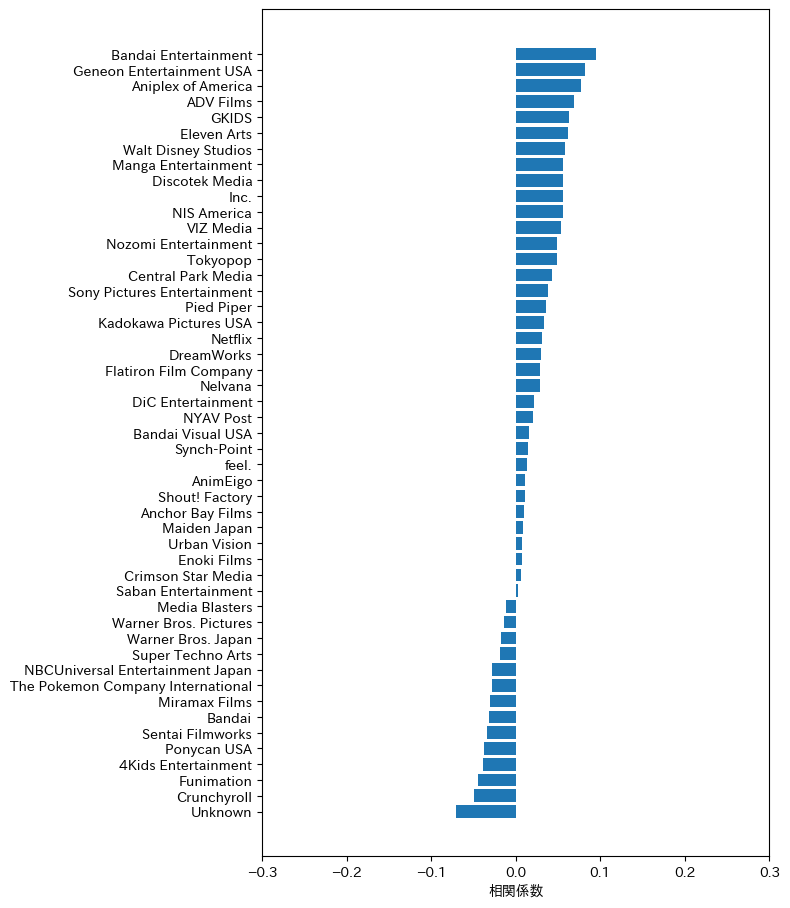

In [66]:
res_licensors = get_corr_df(anime, "licensors")
view_barh_plot(res_licensors)

In [67]:
display_filter_df(anime, "licensors", "Bandai Entertainment")

licensors,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Funimation, Bandai Entertainment""","""コードギアス 反逆のルルーシュ 続編""",8.941704,446
"""ADV Films, Bandai Entertainment, Aniplex of America""","""天元突破グレンラガン""",8.80719,306
"""Funimation, Bandai Entertainment""","""コードギアス 反逆のルルーシュ""",8.8,475
"""Funimation, Bandai Entertainment""","""カウボーイビバップ""",8.784091,264
"""Funimation, Bandai Entertainment""","""涼宮ハルヒの消失""",8.772455,167
"""Bandai Entertainment, Manga Entertainment""","""攻殻機動隊 S.A.C. 2nd GIG""",8.6875,48
"""Funimation, Bandai Entertainment""","""日常""",8.631579,133
"""Bandai Entertainment, Manga Entertainment""","""攻殻機動隊 STAND ALONE COMPLEX""",8.587302,63
"""Funimation, Bandai Entertainment""","""ストレンヂア -無皇刃譚-""",8.413462,104


In [68]:
display_filter_df(anime, "licensors", "Unknown")

licensors,japanese_name,anime_score_mean,anime_score_count
str,str,f64,u32
"""Unknown""","""獣の奏者エリン""",9.25,8
"""Unknown""","""銀魂'""",9.208791,91
"""Unknown""","""昭和元禄落語心中～助六再び篇～""",9.193548,31
"""Unknown""","""劇場版 銀魂 完結篇 万事屋よ永遠なれ""",9.119403,67
"""Unknown""","""冴えない彼女の育てかた Fine""",9.111111,9
"""Unknown""","""夏目友人帳 陸""",9.038462,26
"""Unknown""","""生徒会役員共＊ OAD""",9.0,1
"""Unknown""","""劇場版 ヴァイオレット・エヴァーガーデン""",9.0,4
"""Unknown""","""銀魂' 延長戦""",8.967213,61


# genres, studios, producers, licensorsの相関の絶対値を比較する

In [69]:
pl.concat(
    [
        res_genres.with_columns(pl.lit("genres").alias("col")),
        res_studios.with_columns(pl.lit("studios").alias("col")),
        res_producers.with_columns(pl.lit("producers").alias("col")),
        res_licensors.with_columns(pl.lit("licensors").alias("col")),
    ]
).groupby("col").agg(
    pl.col("corr_anime_score_mean").max().alias("max_corr"),
    pl.col("corr_anime_score_mean").min().alias("min_corr"),
).sort("max_corr",descending=True)

col,max_corr,min_corr
str,f64,f64
"""genres""",0.205904,-0.253379
"""producers""",0.144485,-0.136703
"""studios""",0.123171,-0.108876
"""licensors""",0.095053,-0.070616


`genres`, `studios`, `producers`, `licensors`の中では、`genres`が正の相関、負の相関が共に最も高いことが分かりました。

# 最後に
見ているだけで楽しいデータですね。atmacup開催、本当にありがとうございます。